# Word2Vec in non-NLP context

### In this notebook, we enconde movies' cast and crew into vectors and use them  to predict the probability of any given movie being among the 1% with most IMDB votes

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score, precision_score, recall_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm.notebook import tqdm
import csv
from gensim.models.callbacks import CallbackAny2Vec
from itertools import groupby
from gensim.models import Word2Vec
import gensim
from pathlib import Path
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

In [2]:
# PATH = Path('../../data')
PATH = Path('C:/Users/gmanf/OneDrive/Documents/Data Science/Curso ML Practico/ml-practico\data_kaggle')

# Load Data

In [3]:
def load_data(start_year, min_minutes, min_votes):
    title_basics = pd.read_csv(PATH / 'title.basics.tsv', sep='\t')
    title_ratings = pd.read_csv(PATH / 'title.ratings.tsv', sep='\t')
    title_basics.genres = title_basics.genres.apply(
                                        lambda x: x.split(',') if ((type(x)!=float) & (x!=r'\N')) else ['no_genre'])

    title_basics.runtimeMinutes = (
        title_basics.runtimeMinutes.apply(lambda x: np.nan if not x.isdigit() else x).astype(float)
                                )
    
    title_basics = title_basics[
        title_basics.titleType.isin(['movie'])
        & ~title_basics.runtimeMinutes.isna()
        & (title_basics.runtimeMinutes <= 3.5 * 60)
        & title_basics.genres.apply(lambda x: 'Short' not in x)
        ]
    
    movies = pd.merge(title_basics, title_ratings, on='tconst', how='left')
    movies['startYear'] = movies['startYear'].apply(lambda x: np.nan if x == r'\N' else int(x))
    
    # MY CONDITIONS:
    movies = movies[movies.startYear > start_year].dropna(subset=['averageRating'])
    movies = movies[movies.runtimeMinutes >= min_minutes]
    movies = movies[movies.numVotes>=min_votes]
    return movies

In [4]:
PATH = Path('C:/Users/gmanf/OneDrive/Documents/Data Science/Curso ML Practico/ml-practico\data_kaggle')

I impose a couple of conditions to make the dataset more manageable:

1- Only load movies from after 1960, as I suspect films older than that have a different voting pattern. The choice of 1960 as the cutoff is kind of subjective though.

2- Only load movies > 60 minutes long. It appears that the convention of the minimum duration to be considered a movie is either 40 or 80 minutes depending on the source. So I take 60 minutes which is in the middle of both and makes sense to me.

3- Only load movies with at least 15 votes. With this we get rid of entries that are not even worth looking into (less than 15 votes means that not even the people involved in the movie appears to have voted for it).

In [5]:
movies = load_data(start_year = 1960, min_minutes = 60, min_votes = 15)

C:\Users\gmanf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
principals = pd.read_csv(PATH / 'title.principals.tsv', delimiter="\t")

In [7]:
movies.head(2)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
3591,tt0015724,movie,Dama de noche,Dama de noche,0,1993.0,\N,102.0,"[Drama, Mystery, Romance]",6.2,20.0
16751,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,\N,118.0,"[Comedy, Fantasy, Romance]",6.4,75327.0


We divide our "principals" dataset into "cast" (actors and actresses) and the rest.
The idea is to add to our Movies dataframe two columns: one with a list containing all actors/actresses in the movie, and another including all other crew members who were involved in the movie.

In [8]:
cast = principals[principals['category'].isin(['actor', 'actress'])]
crew = principals[~principals['category'].isin(['actor', 'actress', 'self'])]

In [9]:
ordered_cast = pd.DataFrame(cast.groupby(by='tconst').apply(lambda x: [x for x in x['nconst']]))

In [10]:
ordered_cast = ordered_cast.reset_index().rename(columns={0: 'cast'})

In [11]:
ordered_cast.head(2)

,tconst,cast
0,tt0000005,"[nm0443482, nm0653042]"
1,tt0000007,"[nm0179163, nm0183947]"


In [12]:
# If it went right, we should have no duplicated movies (tconst)
ordered_cast.duplicated('tconst').any()

False

In [13]:
ordered_crew = pd.DataFrame(crew.groupby(by='tconst').apply(lambda x: [x for x in x['nconst']]))

In [14]:
ordered_crew = ordered_crew.reset_index().rename(columns={0: 'crew'})

In [15]:
ordered_crew.head(2)

,tconst,crew
0,tt0000001,"[nm0005690, nm0374658]"
1,tt0000002,"[nm0721526, nm1335271]"


In [16]:
# If it went right, we should have no duplicated movies (tconst)
ordered_crew['tconst'].value_counts().max()

1

Now we add this information to our movies data.

In [17]:
movies = pd.merge(movies, ordered_cast, on='tconst', how='left').merge(ordered_crew, on='tconst', how='left')

In [18]:
# If it went right, we should have no duplicated movies (tconst)
movies.duplicated('tconst').any()

False

In [19]:
# SANITY CHECK: Back to The Future should have Fox and C. Lloyd within Cast, and Robert Zemeckis within Crew.
movies[movies['tconst']=='tt0088763']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,crew
18543,tt0088763,movie,Back to the Future,Back to the Future,0,1985.0,\N,116.0,"[Adventure, Comedy, Sci-Fi]",8.5,965811.0,"[nm0000150, nm0000502, nm0000670, nm0000417]","[nm0004637, nm0000709, nm0301826, nm0134635, n..."


It worked perfect

In [20]:
movies['cast'].isna().sum()

12268

In [21]:
movies['crew'].isna().sum()

681

We do however have some movies with no cast or crew. Let's check a couple.

In [22]:
movies[movies['cast'].isna()].head(2)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,crew
53,tt0054050,movie,The Making of the President 1960,The Making of the President 1960,0,1963.0,\N,90.0,"[Documentary, History]",7.3,18.0,NaN,"[nm0142216, nm0448123, nm0633271, nm0835799, n..."
214,tt0054770,movie,The Crimebusters,The Crimebusters,0,1962.0,\N,88.0,"[Crime, Drama]",7.3,17.0,NaN,"[nm0818157, nm0725052, nm0300010, nm0683984, n..."


Manually checking these movies, I see that this is indeed the case. These movies have some people involved listed as "self", but nobody listed as actor/actresses. Therefore it makes sense. Let's just fill these movies with 'Unknown' cast/crew.

In [23]:
movies['cast'].fillna('Unknown', inplace=True)
movies['crew'].fillna('Unknown', inplace=True)

# Word2Vec

The idea is to estimate one vector for each person who is involved in a movie. We use the other cast/crew members of a movie as context for the algorithm to learn a vector for a certain person. We need to feed the Word2Vec with a list of sublists in which each of the latter contains the id's of the people involved in each movie. For example, something like:

[nm0000138, nm0000701, nm0000708, nm0000870, nm0365239, nm0000116, nm0484457, nm0000035]

In [774]:
to_wtv = pd.DataFrame(principals.groupby(by='tconst').apply(lambda x: [x for x in x['nconst']])).reset_index().iloc[:, 1]

In [776]:
to_wtv.head(3)

0               [nm1588970, nm0005690, nm0374658]
1                          [nm0721526, nm1335271]
2    [nm0721526, nm5442194, nm1335271, nm5442200]
Name: 0, dtype: object

The following class "Saver" allows us to save the results of the W2V in our disk for future use.

In [711]:
class Saver(CallbackAny2Vec):
    def __init__(self, data_path):
        self.data_path = data_path
        self.epoch = 1
    
    def on_epoch_end(self, model):
        print(f'Finished epoch {self.epoch}. Saving...')
        output_path = self.data_path / 'w2v_new' / f'epoch_{self.epoch}'
        output_path.parent.mkdir(parents=True, exist_ok=True)
        model.save(str(output_path))
        self.epoch += 1

Now we build the Word2Vec model, which requires only a couple of lines of code. We use a window of 10, and 100 length vectors will be estimated for each person using the other people involved in each movie as context.

In [712]:
wtv = Word2Vec(window=10, iter=10, min_count=5, callbacks=[Saver(PATH)])

In [713]:
wtv.build_vocab(to_wtv)

In [714]:
wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=10)

Finished epoch 1. Saving...
Finished epoch 2. Saving...
Finished epoch 3. Saving...
Finished epoch 4. Saving...
Finished epoch 5. Saving...
Finished epoch 6. Saving...
Finished epoch 7. Saving...
Finished epoch 8. Saving...
Finished epoch 9. Saving...
Finished epoch 10. Saving...


(362470430, 410851810)

We can also load the model directly in the future, which is very convenient considering it takes quite a long time.

In [24]:
PATH = Path('C:/Users/gmanf/OneDrive/Documents/Data Science/Curso ML Practico/ml-practico\data')
class Saver(): pass
wtv = Word2Vec.load(str(PATH / 'w2v_new/epoch_10'))

# Results from Word2Vec

The following functions let us turn imdb id's into pictures and names of the cast/crew.

In [25]:
from IPython.display import HTML, display
from bs4 import BeautifulSoup
import requests
import requests_cache

requests_cache.install_cache('imdb')

def get_name(id):
    response = requests.get(f'https://www.imdb.com/name/{id}/')
    soup = BeautifulSoup(response.content)
    return soup.select('.header .itemprop')[0].text

def get_image(id):
    response = requests.get(f'https://www.imdb.com/name/{id}/')
    soup = BeautifulSoup(response.content)
    candidates = soup.select('#name-poster')
    return candidates[0].attrs['src'] if candidates else 'https://m.media-amazon.com/images/G/01/imdb/images/nopicture/medium/name-2135195744._CB466677935_.png'

def render_person(id):
    name = get_name(id)
    picture = get_image(id)
    return f"""
    <div style="width: 150px; text-align: center">
        <h4 style='margin-top: -5px'>{name}</h4>
        <div style='font-size:75%; margin-bottom: 5px'>{id}</div>
        <a href="https://www.imdb.com/name/{id}" target="_blank">
            <img style="width: 100px; display: block; margin-left: auto; margin-right: auto;" src="{picture}"/>
        </a>
    </div>
    """

In [26]:
def show_similars(id, n=10):
    if id in wtv.wv: 
        display(HTML(render_person(id)))
    renders = []
    for similar_id, score in wtv.wv.most_similar(id, topn=n):
        renders.append(render_person(similar_id))
        
    carousel = ''.join(
        [
            f'<div style="margin-left: 10px; float: left">{p}</div>' 
            for p in renders
        ]
        )
    display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

In [27]:
def show_similars_tovector(id, n=10):
    renders = []
    
    for similar_id, score in wtv.wv.most_similar(id, topn=n):
        renders.append(render_person(similar_id))
        
    carousel = ''.join(
        [
            f'<div style="margin-left: 10px; float: left">{p}</div>' 
            for p in renders
        ]
    )
    display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

In [28]:
def who_doesnt_match(person1, person2, person3, person4):
    
    p1 = str(person1); p2=str(person2); p3=str(person3); p4=str(person4); 
    result = wtv.wv.doesnt_match([p1, p2, p3, p4])
    
    if result in wtv.wv: 
        display(HTML(render_person(result)))

Let's check a few similarities

In [29]:
show_similars('nm0000138')

In [716]:
show_similars('nm0000264')

In [719]:
show_similars('nm0000158')

Nice to see that results seem mostly to make a lot of sense :)

Now let's search for a random unkwnown actor. If the W2V representations make sense, we should get other relatively unknown cast/crew.

In [477]:
show_similars('nm4446286')

Indeed, we get a bunch of random unknown people (at least to me), just as we hoped. One of them is actually called Jon Snow, which I find pretty funny.

Of course looking at the vectors themselves make little sense to us humans. But they do appear to make sense to a computer, which is what makes this technique so interesting.
Here's for example how Di Caprio's vector looks like:

In [37]:
wtv.wv['nm0000138']

array([-0.10366471,  0.46839067, -1.2206813 ,  0.3002078 ,  0.178207  ,
        1.6990376 , -0.46968842, -0.0759187 ,  0.83627015, -0.4428964 ,
        0.12417804,  0.20482583, -0.60909355, -1.7934252 , -0.52148175,
        0.34832796,  0.5963028 ,  0.24976212, -1.61199   ,  1.5369637 ,
       -0.09164323, -1.0604653 ,  0.22418326,  0.22463627, -0.36901665,
        1.0456139 ,  1.5883263 , -0.46983522, -0.78857243,  0.32545882,
        0.84453577, -1.0661434 ,  0.7003741 , -0.9967633 ,  2.341712  ,
        0.20226601,  0.7291691 , -0.27283406,  0.775425  , -0.7664714 ,
       -0.75261563,  0.2583464 ,  0.20865093, -0.2554017 , -0.25745627,
       -1.239082  ,  1.2924539 , -1.1842724 ,  0.05884712,  0.04236272,
        0.222534  , -2.4201686 , -0.21548343, -0.6565128 , -0.9076947 ,
        0.775961  , -0.859882  , -0.0978079 ,  0.4925904 , -2.4760904 ,
        1.3713    , -0.19479962,  1.2384449 , -0.38421512,  1.0798846 ,
        0.84606755, -0.9600651 , -0.44379333, -0.83380246,  1.91

Let's play a bit more. W2V has a method called "doesn't match" that returns which element from a list is the one that does not belong in the group. More technically, it computes the center of the group (the mean of all vectors) and then returns the one who is furthest away from this center.

I think this is a great way to check which parts of the cast spectrum are covered by these vectors.

Let's start by checking whether how "famous" the actors are is covered. We have seen already from the previous examples that this indeed seems to be covered.

Fame Checking: I take 3 famous actors/actresses and 1 random. The random one should be the one who doesn't match.

In [441]:
brad_pitt = 'nm0000093'
ben_affleck = 'nm0000255'
edward_norton = 'nm0001570'

In [424]:
import random
random_person = random.sample(list(principals.nconst.unique()), 1)[0]

In [425]:
random_person

'nm4686226'

In [440]:
who_doesnt_match(edward_norton, ben_affleck, brad_pitt, random_person)

Indeed, we get the random person.

Now we'll try it the other way and use three random actors/actresses and one famous actress, who should be the one that does not belong if our model is capturing "fame" right.

In [443]:
angelina_jolie= 'nm0001401'
random1 = random.sample(list(principals.nconst.unique()), 1)[0]
random2 = random.sample(list(principals.nconst.unique()), 1)[0]
random3 = random.sample(list(principals.nconst.unique()), 1)[0]

In [444]:
print(random1, random2, random3)

nm8591246 nm7981642 nm1940999


In [445]:
who_doesnt_match(angelina_jolie, random1, random2, random3)

Age Checking: I take 3 kind of new young stars and one star from the past. Despite being all famous, let's see if the model can differentiate according to which era they belong to.

In [1048]:
paul_newman = 'nm0000056'
joseph_gordon_levitt = 'nm0330687'
jennifer_lawrence = 'nm2225369'
rooney_mara = 'nm1913734'

In [1049]:
who_doesnt_match(paul_newman, joseph_gordon_levitt, jennifer_lawrence, rooney_mara)

Again we see it works pretty well.

To end with, let's see if the models also picks up which kind of genres the actor/actress is usually in. I'll include three (mostly) comedy actors and one more serious-type actor such as Christian Bale, who should not belong here.

In [32]:
christian_bale = 'nm0000288'
will_ferrell = 'nm0002071'
seth_rogen = 'nm0736622'
adam_sandler = 'nm0001191'

In [33]:
who_doesnt_match(christian_bale, will_ferrell, kevin_hart, adam_sandler)

We could keep trying things endlessly but let's end for now.

In summary, we have seen that using word2vec to embedd actors into vectors seem to work pretty well. It looks like these numbers contain information such as how famous the actor/actress is, in which decade he/she worked the most, and the kind of movies he/she is usually in.

Remember that these vectors were assembled by looking at who worked with whom across all movies in our data. So it seems that you can describe an actor/actress pretty well by knowing who he/she has worked with in the past!

Now we should decide what vector to estimate for cast/crew that do not have a vector (because they did not appear in a sufficient minimum number of movies).
I consider two obvious options:

1- We take the np.mean vector of all people.

2- We use a vector full of zeros.

Let's see who are the most similar people to each of these two default vectors:

In [34]:
default_vector = np.mean(wtv.wv.vectors, axis=0)

In [778]:
show_similars_tovector([default_vector])

In [65]:
default_vector = np.zeros(100)

In [780]:
show_similars_tovector([default_vector])

In both cases we get kind of obscure people, which is exactly what we would expect. Not sure what to decide here. For now let's use the np.zeros vector and later we check if we do better the other way.

# Choosing proxy for movies' popularity

I will use the number of IMDB votes as a proxy to measure a movie's popularity.

The goal will be to predict which movies will be among the Top 1% in terms of IMDB votes ( > ~125,000 votes) based on its cast and crew.

We'll call these kinds of movies a "Classic" in our dataset to easily differentiate them from the rest.

In [35]:
np.percentile(movies.numVotes, 99)

123586.37999999936

In [36]:
movies_docs = movies.to_dict(orient='records')
movies['Classic'] = [1 if x['numVotes']>np.percentile(movies.numVotes, 99) else 0 for x in movies_docs]

In [37]:
len(movies[movies['Classic']==1]) / len(movies)

0.01000508240760909

Let's see which are some of these "classic" movies we have.

In [38]:
movies.sort_values('Classic', ascending=False).head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,crew,Classic
58051,tt0347149,movie,Howl's Moving Castle,Hauru no ugoku shiro,0,2004.0,\N,119.0,"[Adventure, Animation, Family]",8.2,291644.0,"[nm0047962, nm0454120, nm0309107, nm0594271]","[nm0386749, nm0594503, nm1168510, nm0218760, n...",1
27312,tt0107362,movie,Last Action Hero,Last Action Hero,0,1993.0,\N,130.0,"[Action, Adventure, Comedy]",6.4,128493.0,"[nm0000216, nm0000719, nm0138770, nm0001097]","[nm0745030, nm0001532, nm0672015, nm0498963, n...",1
88064,tt1605630,movie,American Reunion,American Reunion,0,2012.0,\N,113.0,[Comedy],6.7,194770.0,"[nm0004755, nm0004989, nm0005405, nm0005098]","[nm0956015, nm1375358, nm1376383, nm0381221, n...",1
55004,tt0307901,movie,25th Hour,25th Hour,0,2002.0,\N,135.0,[Drama],7.6,164153.0,"[nm0001570, nm0001608, nm0000450, nm0206257]","[nm0005966, nm0000490, nm1125275, nm0153892, n...",1
65446,tt0443706,movie,Zodiac,Zodiac,0,2007.0,\N,157.0,"[Crime, Drama, Mystery]",7.7,407237.0,"[nm0350453, nm0000375, nm0749263, nm0000381]","[nm0005219, nm0000399, nm0888743, nm1172196, n...",1


Maybe not all of these movies can really be considered actual "classics", but they do have a very large number of votes and are truly famous movies.

# Feature Engineering

### Cast & Crew

The class below takes, for each movie, its entire cast or crew vectors, and then computes the mean of all of them.

The result of this will be one 100-length vector that summarizes the cast or crew that was involved in the movie.

In [39]:
class W2VFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, wtv, category, min_cnt_movies=2):
        self.category = category
        self.min_cnt_movies = min_cnt_movies
        self.wtv = wtv
        self.default_vector = default_vector

    def fit(self, X, y):
        self.default_vector = np.zeros(100)
        #self.default_vector = np.mean(wtv.wv.vectors, axis=0)
        return self
    
    def _get_movie_vector(self, x_i):
        vectors = []
        for person in x_i[self.category]:
            if person not in self.wtv.wv or self.wtv.wv.vocab[person].count < self.min_cnt_movies: continue
            vectors.append(self.wtv.wv[person])
            
        if len(vectors) == 0:
            return self.default_vector
        else:
            return np.mean(vectors, axis=0)
            
    def transform(self, X):
        return np.asarray([self._get_movie_vector(x_i) for x_i in X])

### Other features

There may be some other things, like the Genre of a movie, its Runtime and the Year it was released, that affect the number of votes it gets. For this reason, it is better to include these control variables in order to better understand the effect that the cast has on the movie's popularity.

### RunTime

In [40]:
movies.runtimeMinutes.corr(np.log(movies.numVotes))

0.23239350554642257

We see that there is a weak/moderate correlation between runtime and the number of votes, even though I really doubt this relation is linear (which is what the coefficient above measures). Anyway, looks like we should add RunTime to our model.

In [52]:
class RunTime(BaseEstimator, TransformerMixin):
    def fit(self, X, y): return self
    def transform(self, X):
        res = []
        for e in X:
            res.append({'runTime': int(e['runtimeMinutes'])})
        return res

### Genre

First let's see how balanced/imbalanced the genres are in our data according to whether they are "classic" movies:

In [53]:
class GenreDummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y): return self
    def transform(self, X):
        res = []
        for e in X:
            res.append({g: 1 for g in e['genres']})
        return res  

In [504]:
v = DictVectorizer(sparse=False)

In [505]:
dummies_genre = v.fit_transform(GenreDummies().transform(movies_docs))

In [506]:
df_genres = pd.DataFrame(dummies_genre, columns=v.feature_names_)
df_genres = df_genres.astype(int)
genres_analysis = pd.concat([movies, df_genres], axis=1)

In [507]:
graph1 = pd.DataFrame(genres_analysis[genres_analysis['numVotes'] > np.percentile(genres_analysis.numVotes,97)].iloc[:,14:-1] \
                     .sum(axis=0) / len(genres_analysis[genres_analysis['numVotes'] > \
                    np.percentile(genres_analysis.numVotes,97)])).reset_index().rename(columns={'index': 'genre', 0: 'pct'})
graph1['classic']="Classic"

In [508]:
graph2 = pd.DataFrame(genres_analysis.iloc[:,14:-1] \
                     .sum(axis=0) / len(genres_analysis)).reset_index().rename(columns={'index': 'genre', 0: 'pct'})
graph2['classic'] = "All"

In [509]:
graph = pd.concat([graph1, graph2], axis=0) 

Text(0.5, 1.0, '% of total movies per genre (1960-2020)')

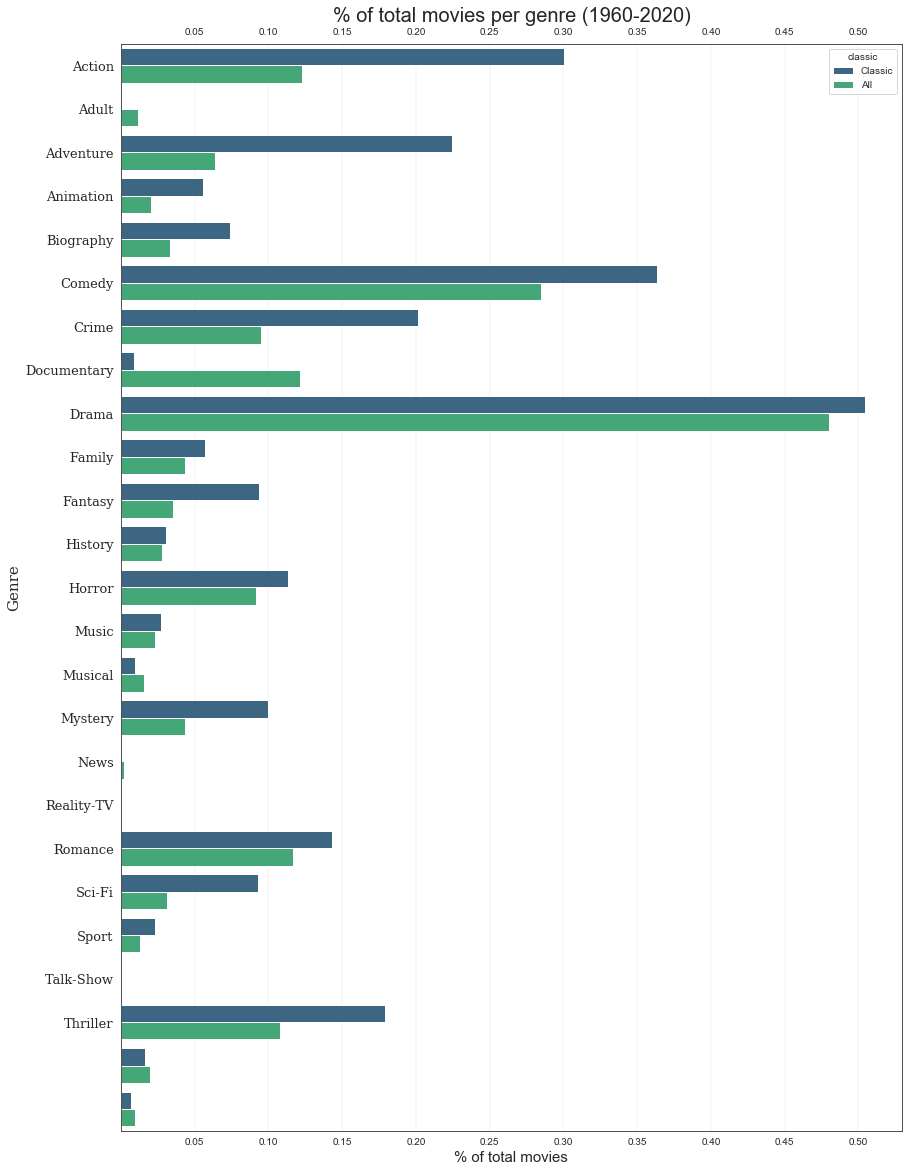

In [510]:
import seaborn as sns
sns.set_style("white")
fig, ax = plt.subplots(figsize=(14,20))
ax = sns.barplot(y='genre', x='pct', hue='classic', data=graph, palette='viridis')
ax.grid(color='grey', linestyle='-', linewidth=0.1, axis='x')
ax.set_xticks([0.05, 0.10, .15, .20, .25, .30, .35, .40, .45, .50])
ax.set_yticklabels(graph.genre[:23], size = 13, fontfamily='serif')
ax.set_xlabel('% of total movies', fontsize=15)
ax.set_ylabel('Genre', fontsize=15, fontfamily='serif')
ax.tick_params(labelbottom=True,labeltop=True)
plt.title('% of total movies per genre (1960-2020)', fontsize=20)

We find some very clear differences, mostly in the genres Action and Adventure.

We see that Action movies comprise around 12% of total movies, but 30% of these so-called "classic" movies belong to the Action genre. We find a similar situation with the Adventure genre movies. This suggests that we must control for a movie's genre in the model.

Let's see now how certain genres' popularity has evolved through time.

In [511]:
genres_prog = genres_analysis.groupby(by='startYear').agg({'Horror': 'sum', 'Comedy': 'sum', \
                                                           'Drama':'sum', 'Sci-Fi':'sum', 'tconst': 'count'})

In [512]:
genres_prog.reset_index(inplace=True)
genres_prog['%_horror'] = genres_prog['Horror'] / genres_prog['tconst'] * 100
genres_prog['%_comedy'] = genres_prog['Comedy'] / genres_prog['tconst'] * 100
genres_prog['%_drama'] = genres_prog['Drama'] / genres_prog['tconst'] * 100
genres_prog['%_scifi'] = genres_prog['Sci-Fi'] / genres_prog['tconst'] * 100
genres_prog = genres_prog.iloc[:-1,:]

Text(0.5, 1.0, 'Progression of Horror films through time')

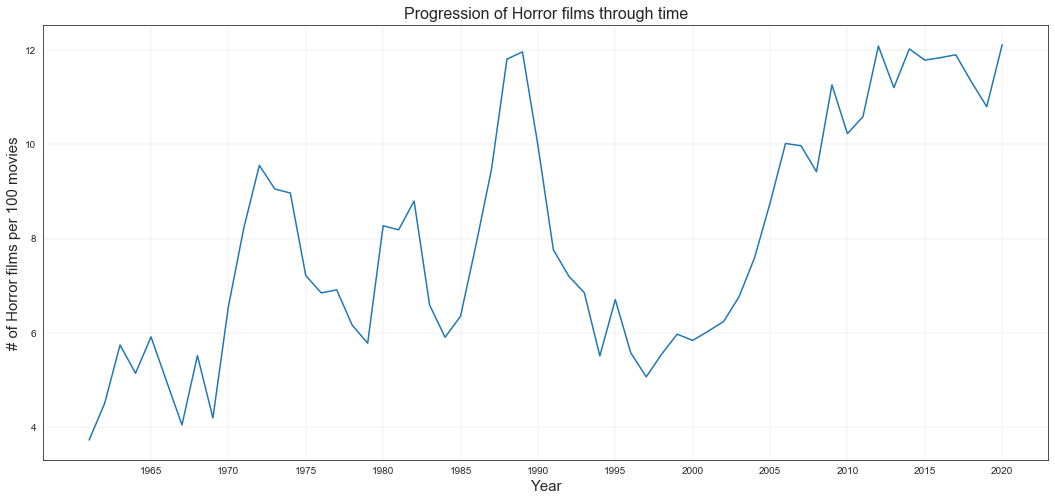

In [513]:
ax = plt.subplots(figsize=(18,8))
ax = sns.lineplot(x=genres_prog['startYear'], y=genres_prog['%_horror'], legend='brief')
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('# of Horror films per 100 movies', fontsize=15)
ax.grid(color='grey', linestyle='-', linewidth=0.1)
ax.set_xticks([1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020])
plt.title('Progression of Horror films through time', fontsize=16)

We see that the production of Horror films decreased heavily during the 90's after the golden age of the genre in the 80's. It then started slowly increasing again after year 2000.

Text(0.5, 1.0, 'Progression of Sci-Fi films through time')

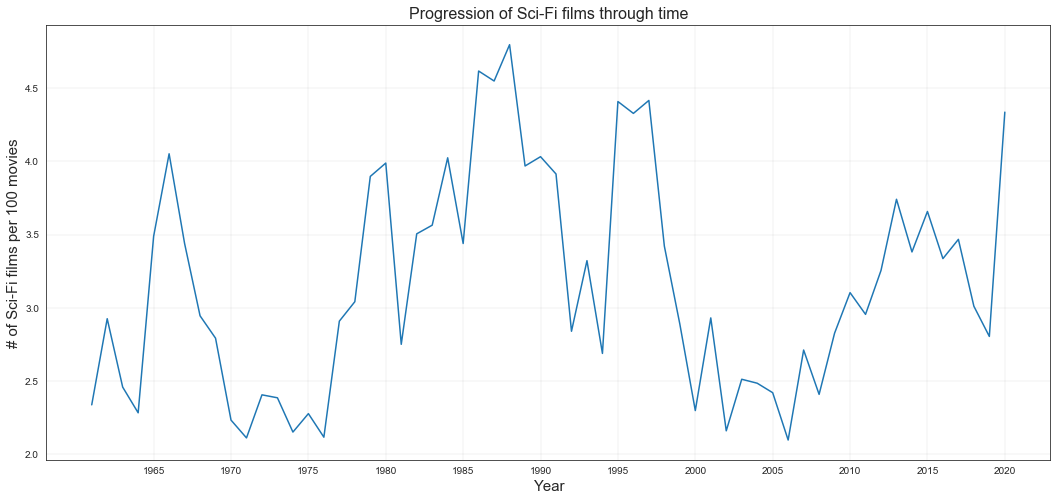

In [514]:
ax = plt.subplots(figsize=(18,8))
ax = sns.lineplot(x=genres_prog['startYear'], y=genres_prog['%_scifi'], legend='brief')
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('# of Sci-Fi films per 100 movies', fontsize=15)
ax.grid(color='grey', linestyle='-', linewidth=0.1)
ax.set_xticks([1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020])
plt.title('Progression of Sci-Fi films through time', fontsize=16)

### Year of Release

In [54]:
class ReleaseYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y): return self
    def transform(self, X):
        res = []
        for e in X:
            res.append({'release_year': int(e['startYear'])})
        return res

Text(0.5, 1.0, 'Year vs. logVotes')

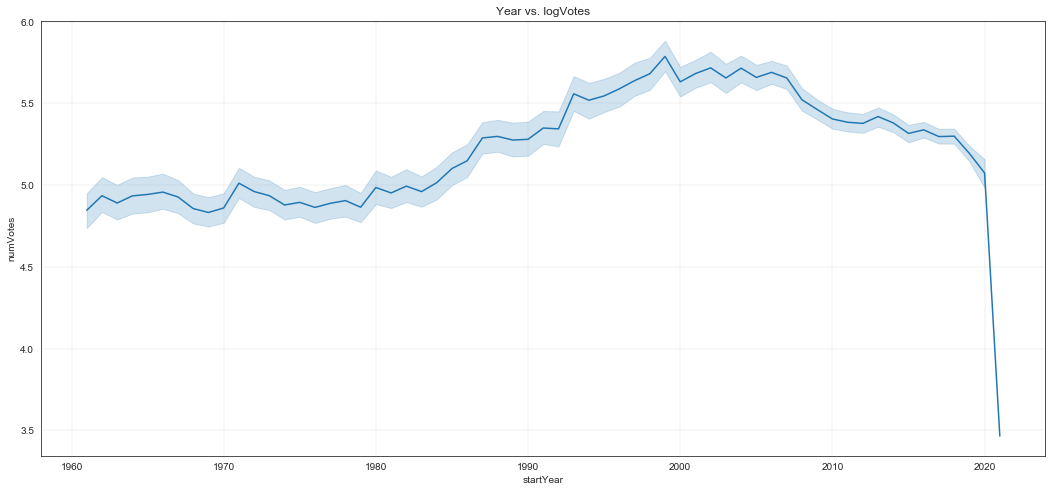

In [516]:
ax = plt.subplots(figsize=(18,8))
ax = sns.lineplot(x=movies['startYear'], y=np.log(movies['numVotes']))
ax.grid(color='grey', linestyle='-', linewidth=0.1)
plt.title('Year vs. logVotes')

We see that the number of votes increases until the beginning of the 00's and then slowly goes down. It seems to make sense to control for Year of Release of the movies.

# Train/Test Split

I'll use only movies after 1980 for training to reduce our data a bit and the needed computation power.

To achieve a more realistic predictive scenario, I'll use movies from 1980-2016 for training, and movies from 2017-2020 for testing.

In [80]:
train_df = movies[movies.startYear.isin(range(1975,2016))]
test_df = movies[movies.startYear.isin(range(2016,2020))]
len(train_df), len(test_df), len(test_df) / len(train_df)

(100330, 21305, 0.21234924748330508)

In [81]:
print(len(train_df[train_df['Classic']==1]) / len(train_df))
print(len(test_df[test_df['Classic']==1]) / len(test_df))

0.012020332901425297
0.006618164750058672


We have 1.25% of positive examples in our training set, and only 0.6% in our testing set. This is not ideal, but I still prefer to train on older movies and test on more recent ones, as it is a more useful scenario in practical terms, so I'll keep it this way.

In [82]:
train_docs = train_df.to_dict(orient='records')
test_docs = test_df.to_dict(orient='records')

In [83]:
y_train = (train_df.Classic).values
y_test = (test_df.Classic).values

# Predictive Model

In [84]:
def test_pipe(pipe):
    return {
        'train_auc': roc_auc_score(y_train, pipe.predict_proba(train_docs)[:, 1]),
        'test_auc': roc_auc_score(y_test, pipe.predict_proba(test_docs)[:, 1]),
        'f1':f1_score(y_test, pipe.predict(test_docs)),
        'precision':precision_score(y_test, pipe.predict(test_docs)),
        'recall':recall_score(y_test, pipe.predict(test_docs)),
        'f_05_score': fbeta_score(y_test, pipe.predict(test_docs), beta=0.5)
    }

In [85]:
def see_preds(pipe):
    preds = pipe.predict_proba(test_docs)
    vis = test_df[['tconst','primaryTitle','startYear','runtimeMinutes','genres','numVotes','averageRating', 'Classic'\
                  ]]
    vis['prob_True'] = [preds[i][1] for i in range(len(preds))]
    return vis

In [86]:
def get_features_pipe():
    steps = []
    steps.append(make_pipeline(W2VFeatures(wtv, category='cast', min_cnt_movies=3)))
    steps.append(make_pipeline(W2VFeatures(wtv, category='crew', min_cnt_movies=3)))
    steps.append(make_pipeline(RunTime(), DictVectorizer(sparse=False)))
    steps.append(make_pipeline(GenreDummies(), DictVectorizer(sparse=False)))
    steps.append(make_pipeline(ReleaseYear(), DictVectorizer(sparse=False)))
    res = make_union(*steps)
    return res

def get_model_pipe(features_pipe, scaler, estimator):
    return make_pipeline(features_pipe, scaler, estimator)

In [87]:
features_pipe=get_features_pipe()

In [88]:
model = get_model_pipe(
                        features_pipe,
                        scaler = StandardScaler(), 
                        estimator= LogisticRegression(max_iter=400
                                                     ),
                                             )
model.fit(train_docs, y_train)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('w2vfeatures',
                                                                  W2VFeatures(category='cast',
                                                                              min_cnt_movies=3,
                                                                              wtv=<gensim.models.word2vec.Word2Vec object at 0x0000023D40F37508>))],
                                                          verbose=False)),
                                                ('pipeline-2',
                                                 Pipeline(memory=None,
                                                          steps=[('w2vfeatures',
                                                         

In [89]:
test_pipe(model)

{'train_auc': 0.9870916910410487,
 'test_auc': 0.9919490610979973,
 'f1': 0.5562913907284768,
 'precision': 0.5217391304347826,
 'recall': 0.5957446808510638,
 'f_05_score': 0.535031847133758}

In [89]:
test_pipe(model)

{'train_auc': 0.9870916910410487,
 'test_auc': 0.9919490610979973,
 'f1': 0.5562913907284768,
 'precision': 0.5217391304347826,
 'recall': 0.5957446808510638,
 'f_05_score': 0.535031847133758}

We get an outstanding ROC AUC score of 98% in our testing set.

We have a precision of 59% and a Recall of 60%, both very good values considering that only 0.6% of the examples in the testing set are positive. So there are very few movies that got this number of votes in our test data, but we can correctly identify more than 60% of them with our simple Logistic Regression model.

Let's see some of the predictions to get a more practical feel for what our model is predicting:

In [528]:
see_preds(model).sort_values(by='numVotes', ascending=False).head(10)

C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,tconst,primaryTitle,startYear,runtimeMinutes,genres,numVotes,averageRating,Classic,prob_True
138759,tt7286456,Joker,2019.0,122.0,"[Crime, Drama, Thriller]",859693.0,8.5,1,0.712115
121178,tt4154756,Avengers: Infinity War,2018.0,149.0,"[Action, Adventure, Sci-Fi]",798155.0,8.4,1,0.999856
121179,tt4154796,Avengers: Endgame,2019.0,181.0,"[Action, Adventure, Drama]",757686.0,8.4,1,0.999871
114695,tt3315342,Logan,2017.0,137.0,"[Action, Drama, Sci-Fi]",628395.0,8.1,1,0.721812
97133,tt1825683,Black Panther,2018.0,134.0,"[Action, Adventure, Sci-Fi]",600365.0,7.3,1,0.995712
116201,tt3501632,Thor: Ragnarok,2017.0,130.0,"[Action, Adventure, Comedy]",565421.0,7.9,1,0.993042
119415,tt3896198,Guardians of the Galaxy Vol. 2,2017.0,136.0,"[Action, Adventure, Comedy]",551012.0,7.6,1,0.919142
108405,tt2527336,Star Wars: Episode VIII - The Last Jedi,2017.0,152.0,"[Action, Adventure, Fantasy]",548345.0,7.0,1,0.968856
67673,tt0451279,Wonder Woman,2017.0,141.0,"[Action, Adventure, Fantasy]",536725.0,7.4,1,0.643241
126516,tt5013056,Dunkirk,2017.0,106.0,"[Action, Drama, History]",533142.0,7.9,1,0.041303


The movies above are the ones with the highest number of votes in the test data. Our model correctly identified all of them as movies that would get >125,000 votes, except for Dunkirk, in which case it failed badly to recognize it as a future Classic.

To better understand what our W2V Cast vectors are doing, let's see how well we would do without the Word2Vec features.

In [529]:
def get_features_pipe():
    steps = []
    steps.append(make_pipeline(RunTime(), DictVectorizer(sparse=False)))
    steps.append(make_pipeline(GenreDummies(), DictVectorizer(sparse=False)))
    steps.append(make_pipeline(ReleaseYear(), DictVectorizer(sparse=False)))
    res = make_union(*steps)
    return res

def get_model_pipe(features_pipe, scaler, estimator):
    return make_pipeline(features_pipe, scaler, estimator)

In [530]:
features_pipe=get_features_pipe()

In [531]:
model = get_model_pipe(
                        features_pipe,
                        scaler = StandardScaler(), 
                        estimator= LogisticRegression(max_iter=400
                                                     ),
                                             )
model.fit(train_docs, y_train)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('runtime',
                                                                  RunTime()),
                                                                 ('dictvectorizer',
                                                                  DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                 separator='=',
                                                                                 sort=True,
                                                                                 sparse=False))],
                                                          verbose=False)),
                                                ('pipeli

In [532]:
test_pipe(model)

{'train_auc': 0.8657176119820477,
 'test_auc': 0.9329507575055453,
 'f1': 0.06015037593984962,
 'precision': 0.5714285714285714,
 'recall': 0.031746031746031744,
 'f_05_score': 0.12987012987012986}

We do much worse, as expected. Despite the deceiving 93% ROC AUC in testing, our recall drops to an awful 3.1%.

As a final check to confirm the importance of the W2V features, let's try predicting with those two only.

In [533]:
def get_features_pipe():
    steps = []
    steps.append(make_pipeline(W2VFeatures(wtv, category='cast', min_cnt_movies=3)))
    steps.append(make_pipeline(W2VFeatures(wtv, category='crew', min_cnt_movies=3)))
    res = make_union(*steps)
    return res

def get_model_pipe(features_pipe, scaler, estimator):
    return make_pipeline(features_pipe, scaler, estimator)

In [534]:
features_pipe=get_features_pipe()

In [535]:
model = get_model_pipe(
                        features_pipe,
                        scaler = StandardScaler(), 
                        estimator= LogisticRegression(max_iter=400
                                                     ),
                                             )
model.fit(train_docs, y_train)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('w2vfeatures',
                                                                  W2VFeatures(category='cast',
                                                                              min_cnt_movies=3,
                                                                              wtv=<gensim.models.word2vec.Word2Vec object at 0x0000017C881AE4C8>))],
                                                          verbose=False)),
                                                ('pipeline-2',
                                                 Pipeline(memory=None,
                                                          steps=[('w2vfeatures',
                                                         

In [536]:
test_pipe(model)

{'train_auc': 0.9813784366449506,
 'test_auc': 0.9838350417369489,
 'f1': 0.4725738396624472,
 'precision': 0.5045045045045045,
 'recall': 0.4444444444444444,
 'f_05_score': 0.4912280701754385}

Our performance is reduced, so it seems that the Genre dummies, the Runtime and the Release Year were helping at least somewhat. But the lead stars of this predictive model are the vectors extracted from Word2Vec, as we can see we do very well using those only and nothing else.

In [568]:
trials = Trials()
fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=2,
    trials=trials
);

100%|████████████████████████████████████████████████| 2/2 [09:55<00:00, 297.66s/trial, best loss: -0.5358490566037736]


In [569]:
experiment_results = pd.DataFrame(trials.results)
experiment_results.sort_values(by='loss').head(8)

,hidden_layers,alpha,train_ROCAUC,test_ROCAUC,f1,loss,status
0,"(50, 50, 50)",0.046599,0.996128,0.989351,0.535849,-0.535849,ok
1,"(100, 100, 100)",0.054225,0.996400,0.990726,0.512129,-0.512129,ok


# Algorithm selection

Here it would make sense to try different algorithms and see how much better our predictions can get. Remember that we used a simple linear model. Even though we got very decent results, it is very likely we can do better with an ensemble model such as Gradient Boosting Classifier, or even a MLP neural network.

However, I do not try those here because it takes way too much time for my computer to train any of those complex models. As said before, we still do well with our simple Logistic Regression anyway.

# Probability Distributions

To end this notebook, we'll make use of the fact that our predictive model seems to work pretty well for drawing some probability distributions regarding movies' expected IMDB votes. To do this, we treat this as several different classification problems, in which the target in each case will be numVotes<i.

In [90]:
y_train = train_df.numVotes
y_test = test_df.numVotes

We'll use the following thresholds, one for each classification model we'll make.

In [91]:
thresholds = [np.percentile(movies.numVotes, 10), np.percentile(movies.numVotes, 25), np.percentile(movies.numVotes, 40), \
              np.percentile(movies.numVotes, 55), np.percentile(movies.numVotes, 70), np.percentile(movies.numVotes, 80), \
             np.percentile(movies.numVotes, 85), np.percentile(movies.numVotes, 87.5), np.percentile(movies.numVotes, 90), \
              np.percentile(movies.numVotes, 91.5), np.percentile(movies.numVotes, 93), np.percentile(movies.numVotes, 95),\
              np.percentile(movies.numVotes, 96.5), np.percentile(movies.numVotes, 98),  \
              np.percentile(movies.numVotes, 99), np.percentile(movies.numVotes, 99.25)]

In [92]:
np.percentile(movies.numVotes, 99.5)

224301.94500000062

In [93]:
np.percentile(movies.numVotes, 99.9)

584125.500000004

In [94]:
def get_bools(y):
    res = []
    for t in thresholds:
        res.append(y >= t)
    return res

ys_train = get_bools(y_train)
ys_test = get_bools(y_test)

In [95]:
models = [
        get_model_pipe(
        features_pipe=get_features_pipe(),
        scaler=StandardScaler(),
        estimator=LogisticRegression(max_iter=400)   
    )
    for _ in range(len(thresholds))
]

In [96]:
for i, m in enumerate(models):
    m.fit(train_docs, ys_train[i])

In [97]:
def get_movie_image(id):
    response = requests.get(f'https://www.imdb.com/title/{id}/')
    soup = BeautifulSoup(response.content)
    candidates = soup.find('img',)
    return candidates.attrs['src'] if candidates else 'https://i2.wp.com/www.fryskekrite.nl/wordpress/wp-content/uploads/2017/03/No-image-available.jpg'

def render_movie(id):
    picture = get_movie_image(id)
    return f"""
    <div style="width: 80%; text-align: center">
        <a href="https://www.imdb.com/title/{id}" target="_blank">
            <img style="width: 150px; display: block; margin-left: auto; margin-right: auto;" src="{picture}"/>
        </a>
    </div>
    """

In [100]:
from random import randint
from itertools import compress
from PIL import Image
from io import BytesIO
import seaborn as sns

def prob_dist(tconst):
    sns.set_style("white")
    filt = [x['tconst']==tconst for x in test_docs]
    movie = list(compress(test_docs, filt))[0]
    
    # We plot the movie image on the corner
    response = requests.get(get_movie_image(tconst))
    im = Image.open(BytesIO(response.content))
    im = im.resize((int(im.size[0]*0.40), int(im.size[1]*0.36)))
    height = im.size[1]
    fig, ax = plt.subplots(figsize=(13,8))
    fig.figimage(im, 48, fig.bbox.ymax-height*0.9)
    
    # The following is to make sure the prob distribution starts and ends with zero, and to remove the inconsistencies in which
    # we can end up with Prob<0 if for example Prob(votes>Xi) < Prob(votes>X(i-1).
    preds = np.asarray([m.predict_proba([movie])[0,1] for m in models])
    preds = preds[:-1] - preds[1:]
    preds = np.where(preds<0, 0, preds)
    preds = np.insert(preds, 0,0)
    thresholds_start = np.insert(thresholds,0,10)
    
    # We add more data points to the end of the plot if this is a movie with a lot of votes:
    if movie['numVotes']>np.percentile(movies.numVotes,99):
        y_train_extra = (train_df.numVotes>np.percentile(movies.numVotes,99.5)).values
        y_train_extra2 = (train_df.numVotes>np.percentile(movies.numVotes,99.9)).values
        extra_model = get_model_pipe(
                                        features_pipe=get_features_pipe(),
                                        scaler=StandardScaler(),
                                        estimator=LogisticRegression(max_iter=400)   
                                    )
        extra_model.fit(train_docs, y_train_extra)
        preds = np.insert(preds, len(preds), extra_model.predict_proba([movie])[:,1])
        extra_model.fit(train_docs, y_train_extra2)
        preds = np.insert(preds, len(preds), extra_model.predict_proba([movie])[:,1])
        preds = np.insert(preds, len(preds),0)
        thresholds_start = np.insert(thresholds_start,len(thresholds_start),np.percentile(movies.numVotes,99.5))
        thresholds_start = np.insert(thresholds_start,len(thresholds_start),np.percentile(movies.numVotes,99.9))
        thresholds_start = np.insert(thresholds_start,len(thresholds_start),1500000)
    
    mids = [(x1 + x2) / 2 for x1, x2 in zip(thresholds_start[:-1], thresholds_start[1:])]
    
    ax = sns.lineplot(mids, preds, label='predicted distribution', marker="o")
    plt.plot([movie['numVotes'],movie['numVotes']], [0, preds.max()], color='seagreen', linewidth=1.5, label='true numVotes')
    ax.grid(color='black', linestyle='-', linewidth=0.1)
    plt.xscale("log")
    plt.yticks(np.arange(0,0.75,0.05))
    plt.legend(loc='best', fontsize=13)
    plt.xlabel('Log(numVotes)', fontsize=14, fontfamily='serif')
    plt.ylabel('Probabilty', fontsize=14, fontfamily='serif')
    plt.suptitle('{originalTitle} \n'.format(**movie), fontsize=24, fontfamily='serif')
    plt.title(' \n \n \n ({startYear:.00f}, {genres})\n'.format(**movie), fontsize=16, fontfamily='serif')
    

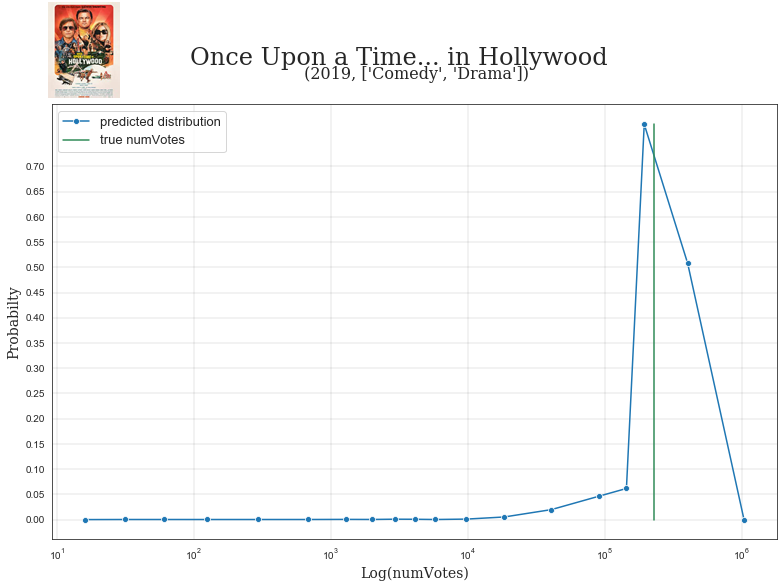

In [101]:
prob_dist('tt7131622')

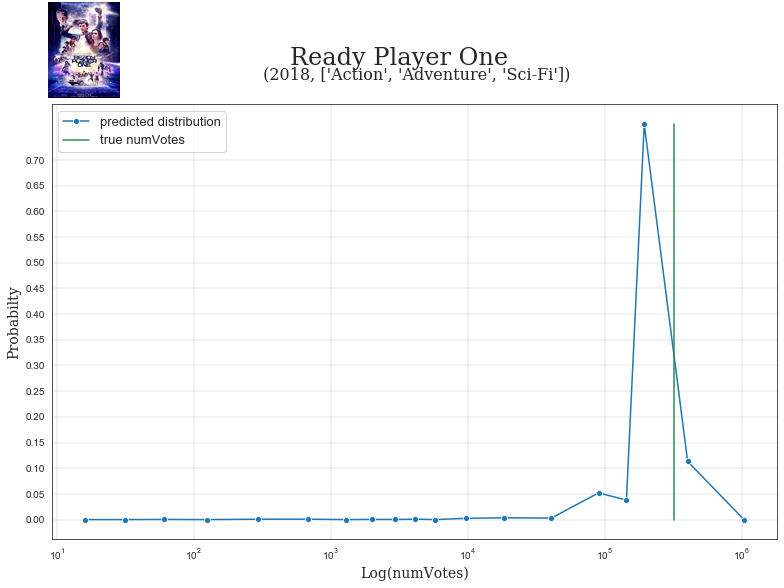

In [110]:
prob_dist('tt1677720')

In [109]:
test_df[test_df.numVotes>300000]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,crew,Classic
66018,tt0451279,movie,Wonder Woman,Wonder Woman,0,2017.0,\N,141.0,"[Action, Adventure, Fantasy]",7.4,507364.0,"[nm2933757, nm1517976, nm0000705, nm0205063]","[nm4243936, nm0420941, nm0374302, nm0811583, n...",1
74067,tt0974015,movie,Justice League,Justice League,0,2017.0,\N,120.0,"[Action, Adventure, Fantasy]",6.4,345977.0,"[nm0000255, nm2933757, nm0597388, nm3009232]","[nm1189346, nm0811583, nm0796950, nm0795975, n...",1
79425,tt1211837,movie,Doctor Strange,Doctor Strange,0,2016.0,\N,115.0,"[Action, Adventure, Fantasy]",7.5,541717.0,"[nm1212722, nm0252230, nm1046097, nm0938950]","[nm0270559, nm0220600, nm3123612, nm1803036, n...",1
80767,tt1270797,movie,Venom,Venom,0,2018.0,\N,112.0,"[Action, Sci-Fi, Thriller]",6.7,312671.0,"[nm0362766, nm0931329, nm1981893, nm2020278]","[nm2163440, nm0281508, nm0684374, nm0003298, n...",1
82954,tt1355644,movie,Passengers,Passengers,0,2016.0,\N,116.0,"[Drama, Romance, Sci-Fi]",7.0,320859.0,"[nm2225369, nm0695435, nm0790688, nm0000401]","[nm0605775, nm0878763, nm3123612, nm1336500, n...",1
83499,tt1386697,movie,Suicide Squad,Suicide Squad,0,2016.0,\N,123.0,"[Action, Adventure, Fantasy]",6.0,554234.0,"[nm0000226, nm0001467, nm3053338, nm0205626]","[nm1664042, nm0043742, nm1694619, nm0746273, n...",1
83695,tt1396484,movie,It,It,0,2017.0,\N,135.0,[Horror],7.3,408581.0,"[nm0803889, nm5897057, nm6016511, nm6096118]","[nm0334381, nm0615592, nm1286060, nm1560977, n...",1
84375,tt1431045,movie,Deadpool,Deadpool,0,2016.0,\N,108.0,"[Action, Adventure, Comedy]",8.0,846098.0,"[nm0005351, nm1072555, nm2554352, nm4534098]","[nm0432725, nm1783265, nm1014201, nm1116660, n...",1
85269,tt1477834,movie,Aquaman,Aquaman,0,2018.0,\N,143.0,"[Action, Adventure, Fantasy]",7.0,311721.0,"[nm0597388, nm1720028, nm0000353, nm0933940]","[nm0918816, nm1490123, nm0424901, nm3263825, n...",1
89616,tt1677720,movie,Ready Player One,Ready Player One,0,2018.0,\N,140.0,"[Action, Adventure, Sci-Fi]",7.5,320329.0,"[nm4446467, nm4972453, nm0578853, nm2913119]","[nm1069736, nm0000229, nm0672015, nm2094392, n...",1


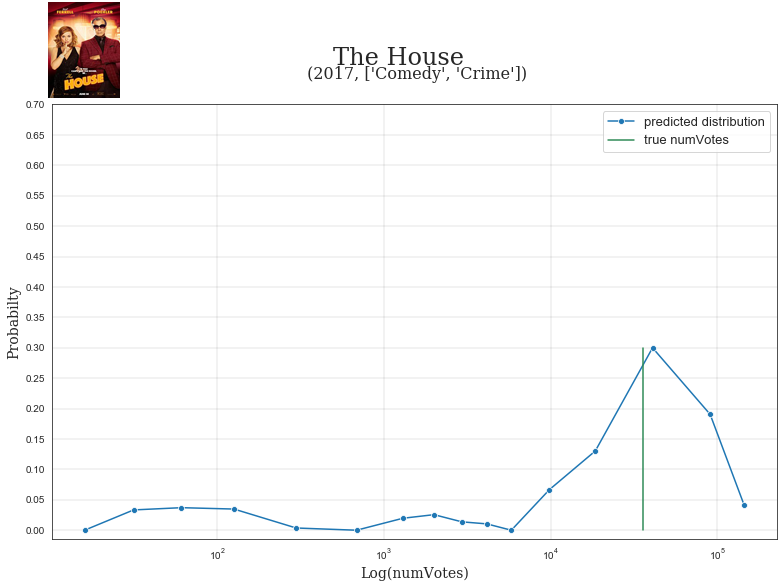

In [103]:
prob_dist('tt4481514')

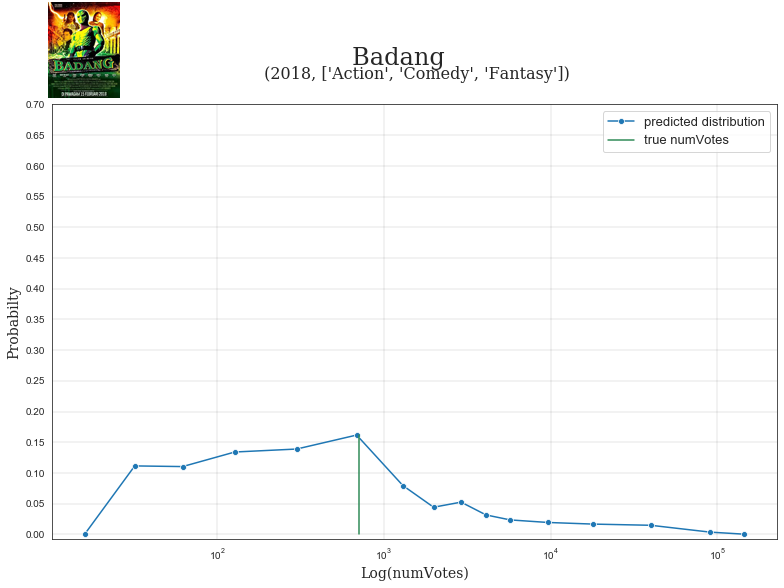

In [1314]:
prob_dist('tt7923374')

And here I found a couple in which the model fails, just to show that even though we created a model that is very good at identifying top 1% movies, we do not always make good predictions when we go to mid or low ranges of votes.

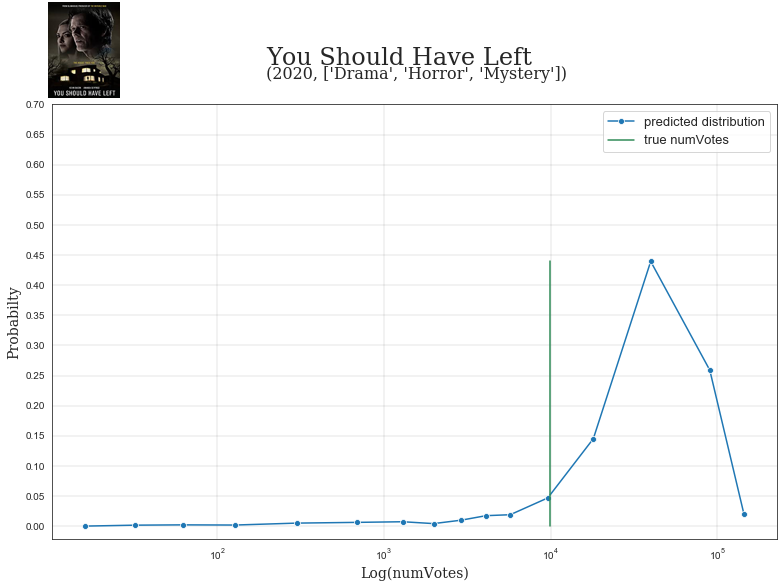

In [1317]:
prob_dist('tt8201852')

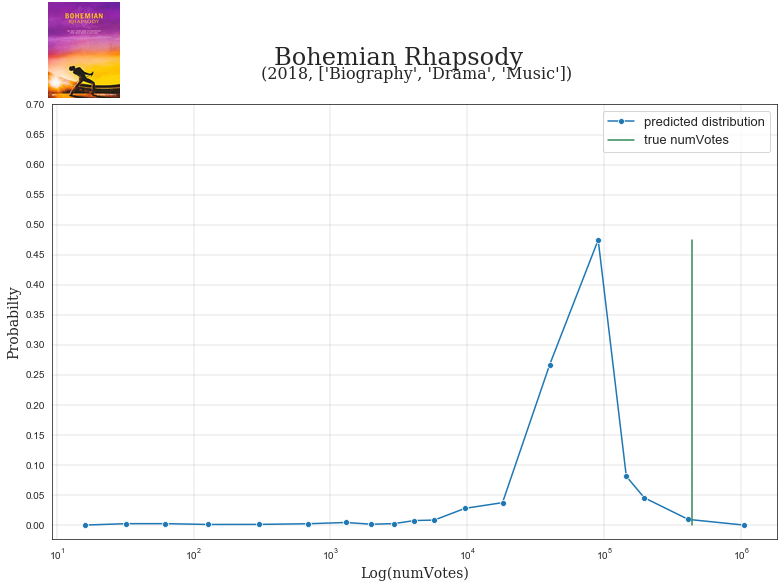

In [1315]:
prob_dist('tt1727824')

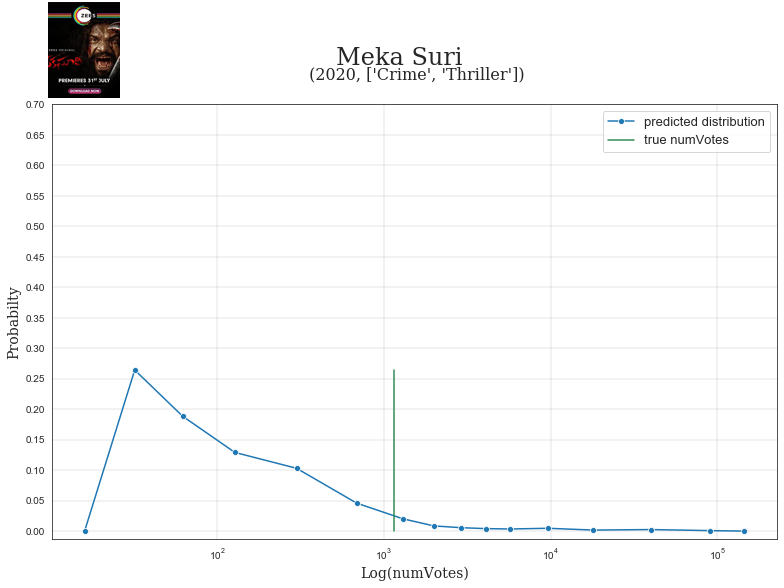

In [1316]:
prob_dist('tt12747588')